# Lab Assignment Six: Convolutional Network Architectures

## Dataset Selection
Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

### I select the image data I used in Lab2. It was got from [kaggle](https://www.kaggle.com/omkargurav/face-mask-dataset). The image datas are collected from google search engine and from Prajna Bhandary's Github repo. I would use 2048 with mask images and another 2048 without mask image as my dataset to do a binary classification task of mask detection. As I said in Lab2, it can be deployed somewhere near the entrance of a shopping mall or hotel to ensure anyone who wants to enter the place to wear a face mask.

## 1. Preparation (3 points total)  
- [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
- [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [1]:
#import the lib needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from PIL import Image
from numpy import random
import skimage
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import average
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import  Model
from tensorflow.keras.utils import plot_model


%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

print("numpy version is:",np.__version__)
print("pandas version is:",pd.__version__)
print("Pillow version is:",Image.__version__)
print("skimage version is:",skimage.__version__)

numpy version is: 1.18.5
pandas version is: 1.2.4
Pillow version is: 8.2.0
skimage version is: 0.18.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
%%time
#Because the image files I got is pre-classfied, to meet the requirement of this assignment, I would put 2048 each of with-mask image files and without-mask image files into another directory. Since the image files are different sizes, I need to pick the size greater than 128*128 and make it as my dataset after resizing.
path_with_masks = "./data/mask_data/with_mask"
path_without_masks = "./data/mask_data/without_mask"
path_train_uniform_dataset = "./data/mask_data/train_uniform_dataset.nosync"

with_masks_prefix = "with_mask_"
without_mask_prefix = "without_mask_"

files_with_masks = os.listdir(path_with_masks)
files_without_masks = os.listdir(path_without_masks)
print("with_mask original size is:",len(files_with_masks))
print("without_mask original size is:",len(files_without_masks))
pick_img_number = 2048
image_uniform_size = [128,128]#the size of image after resizing

if False == os.path.exists(path_train_uniform_dataset):
    os.mkdir(path_train_uniform_dataset)
    count = 0
    for i in range(len(files_with_masks)):
        #convert image file to RGB color
        img_with_mask_tmp = Image.open(os.path.join(path_with_masks,with_masks_prefix+str(i+1)+".jpg"),'r').convert("RGB")
        img_without_mask_tmp = Image.open(os.path.join(path_without_masks,without_mask_prefix+str(i+1)+".jpg"),'r').convert("RGB")
        img_with_mask_tmp = img_with_mask_tmp.resize(image_uniform_size,Image.ANTIALIAS)
        img_without_mask_tmp = img_without_mask_tmp.resize(image_uniform_size,Image.ANTIALIAS)
        img_with_mask_tmp.save(os.path.join(path_train_uniform_dataset,with_masks_prefix+str(i+1)+".jpg"))
        img_without_mask_tmp.save(os.path.join(path_train_uniform_dataset,without_mask_prefix+str(i+1)+".jpg"))
        count += 1
        if (count>=pick_img_number): break

# for img in os.listdir(path_train_uniform_dataset):
print("the dataset is :",len(os.listdir(path_train_uniform_dataset)))

with_mask original size is: 3710
without_mask original size is: 3828
the dataset is : 4096
CPU times: user 1.18 ms, sys: 4.57 ms, total: 5.74 ms
Wall time: 5.38 ms


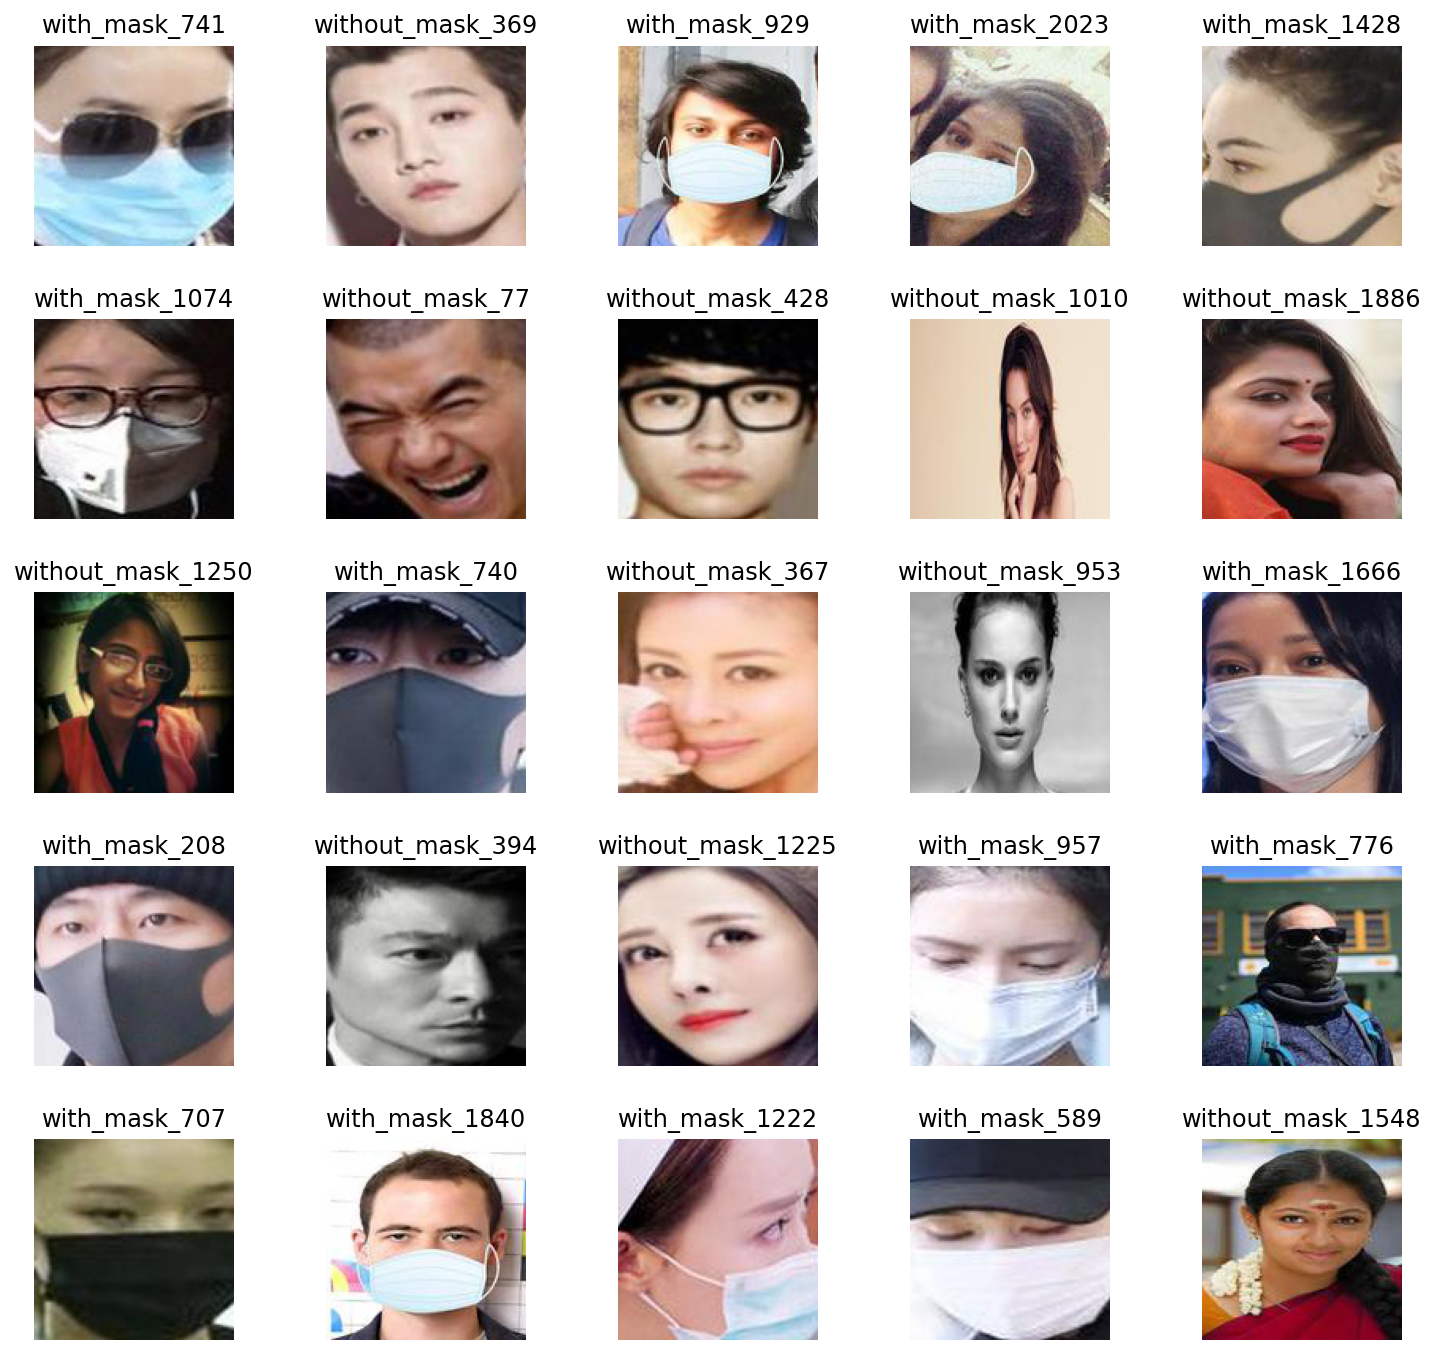

In [4]:
#display several resized images
def plot_raw_gallery(n_row=5, n_col=5):
    plt.figure(figsize=(2*n_col, 2*n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    total = n_row * n_col
    i = 1
    for img_name in os.listdir(path_train_uniform_dataset):
        plt.subplot(n_row, n_col, i)
        img_tmp = plt.imread(os.path.join(path_train_uniform_dataset,img_name))
        plt.imshow(img_tmp)
        plt.title(img_name[:-4], size=12)
        plt.xticks(())
        plt.yticks(())
        i += 1
        if i > total: break

#display a few images resized
plot_raw_gallery()

In [5]:
%%time
train_img_name_list = os.listdir(path_train_uniform_dataset)

X = np.array([np.array(Image.open(os.path.join(path_train_uniform_dataset,img_name))) for img_name in train_img_name_list])#image data
# standardize the data
X = X/255 - 0.5
y = np.array([img_name.count("with_mask_") for img_name in train_img_name_list])#target value

print(X.shape)
print(y.shape)

(4096, 128, 128, 3)
(4096,)
CPU times: user 1.11 s, sys: 183 ms, total: 1.3 s
Wall time: 1.3 s


### 1.1 Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

### I would use accuracy as the metric for my classification task because I have equal number of samples belonging to each class. In terms of even to any class, I can easily get rid of the hassle that a model always says yes all the time which may occur in an imbalanced dataset, though high accuracy. Besides, as I mentioned above, for the scenario of mask dectection deploed somewhere near the entrance of the building, high accuracy is enough.

[2048 2048]


(array([2048.,    0.,    0., 2048.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 <BarContainer object of 4 artists>)

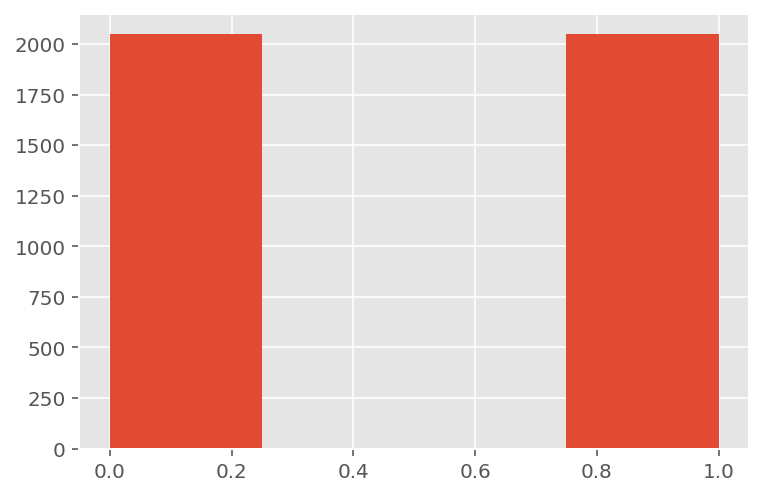

In [6]:
print(np.bincount(y))
plt.hist(y,bins=4)

### 1.2 Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

### I would use 80-20 traning and testing split because it's a totally balanced dataset. Besides, to improve computational efficiency, I do not use K-fold here though I think it is good idea to evaluate my model. In addition, I also take a look at the maximum, minimum, mean and standard deviation value of my training and testing set. The difference between them is slight, hence I think they would not bother too much. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_train.shape[1:])
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3276, 128, 128, 3)
(128, 128, 3)
(820, 128, 128, 3)
(3276,)
(820,)


In [8]:
print(np.min(X_train),np.max(X_train),np.mean(X_train),np.std(X_train))
print(np.min(X_test),np.max(X_test),np.mean(X_test),np.std(X_test))

-0.5 0.5 0.006053789826755799 0.29858769604266094
-0.5 0.5 0.006004794932772396 0.29530258853693653


## 2. Modeling (6 points total)
- [1.5 points]  Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 
- [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).
- [1.5 points] Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 
- [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

### 2.1 Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset.

### I use rescale to normalize the image dataset, rotation_range to roatate a little angle, width_shift_range and height_shift_range to control the amount of of horizontal and vertical shift respectively, zoom_range to randomly zoom the image in, horizontal_flip to randomly flip inputs horizontally, because, in pratice, the image of face photo taken by the machine may not be unified. People usually don't just sit or stand still waiting for shot by the machine so the face photos taken may look like different from standard photos such as Passport photos.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range = [0.8,1.2],
    horizontal_flip = True,
    fill_mode='nearest'
)
train_iter = train_data_gen.flow(X_train,y_train,batch_size=32)
test_iter = (X_test,y_test)

### I show some of the image with mask and without mask after augmentation. It seems well mirroring the pictures taken in the realistic.

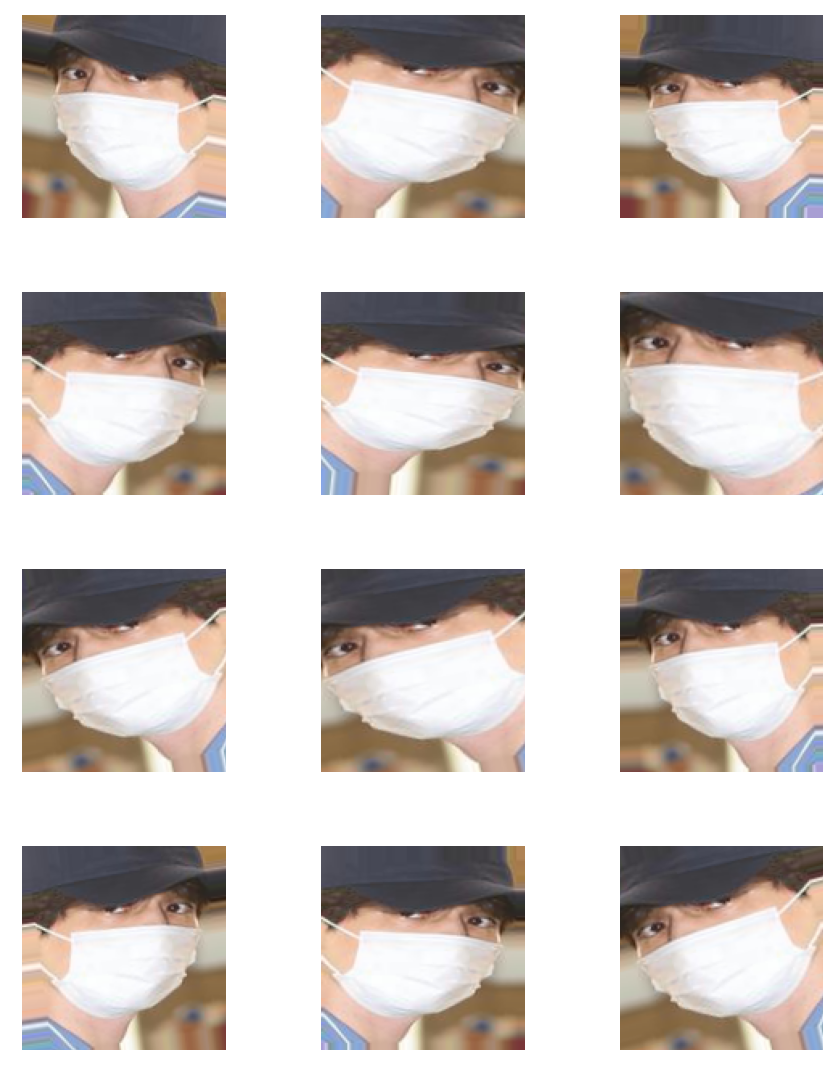

In [10]:
# since I have standardized the data, 
def image_wrapper(transformed_img):
    return ((transformed_img+0.5)*255).astype(int)

def plot_gallery(iterator,n_row=4, n_col=3):
    plt.figure(figsize=(2*n_col, 2*n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    total = n_row * n_col
    for i in range(total):
        batch  = iterator.next()
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(image_wrapper(batch[0]))
        plt.xticks(())
        plt.yticks(())

plot_gallery(train_data_gen.flow(np.expand_dims(X[46],0),batch_size=1))

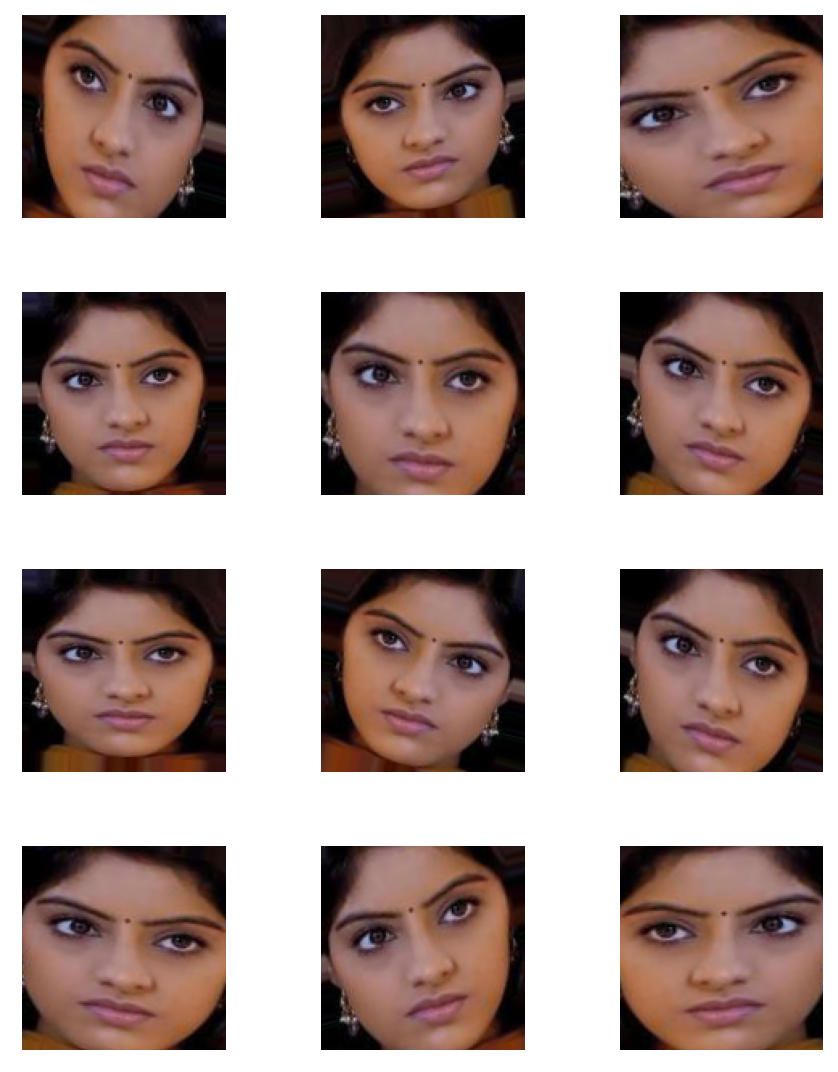

In [11]:
plot_gallery(train_data_gen.flow(np.expand_dims(X[49],0),batch_size=1))

### 2.2 Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).

### 2.3 Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 

### CNN model with 1 convolution layer, 1 max pooling, 1 flatten and 2 neural network. I would call it CNN model 1.

In [12]:
%%time

NUM_CLASSES = 1

# make a CNN with conv layer and max pooling
cnn1 = Sequential() 
cnn1.add(
    Conv2D(filters=10, kernel_size=3, strides=1, padding='same', activation='relu',input_shape=(X_train.shape[1:]),data_format="channels_last")
)
cnn1.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), data_format="channels_last") 
)

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add(Dense(16,activation='relu'))
cnn1.add( Dense(NUM_CLASSES,activation='sigmoid') )

cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                655376    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 655,673
Trainable params: 655,673
Non-trainable params: 0
_________________________________________________________________
CPU times: user 224 ms, sys: 76.8 ms, total: 301 ms
Wall time: 347 ms


### The same architecture of CNN model above with variations altered. I have changed filter size, max pooling size, loss function and optimizer. I would call it CNN 2 model.

In [13]:
# make a CNN with conv layer and max pooling
cnn2 = Sequential() 
cnn2.add(
    Conv2D(filters=30, kernel_size=3, strides=1, padding='same', activation='relu',input_shape=(X_train.shape[1:]),data_format="channels_last")
)
cnn2.add(MaxPooling2D(pool_size=(3, 3), data_format="channels_last") 
)

# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add(Dense(16,activation='relu'))
cnn2.add( Dense(NUM_CLASSES,activation='sigmoid') )

cnn2.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 30)      840       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 30)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 52920)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                846736    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 847,593
Trainable params: 847,593
Non-trainable params: 0
_________________________________________________________________


In [14]:
def plot_metrics(history,label):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        # plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train ' + label)
        plt.plot(history.epoch, history.history['val_'+metric],linestyle="--", label='Val ' + label)
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric != 'loss':
            plt.ylim([0,1])
        plt.title('{}'.format(metric))
        plt.legend()
        plt.show()

In [15]:
def evaluate_model(model,train_iter,test_iter,y_test,model_name,epochs=50,verbose=1): 
    h = model.fit(train_iter,
        steps_per_epoch=len(train_iter), 
        epochs=epochs, 
        verbose=verbose,
        shuffle=True,
        callbacks=[EarlyStopping(monitor = 'val_loss', patience = 5)],
        validation_data=test_iter
    )
    plot_metrics(h,model_name)
    # now lets see how well the model performed
    yhat = np.round(model.predict(test_iter[0]).flatten())
    acc = mt.accuracy_score(y_test,yhat)
    fp,tp,_ = mt.roc_curve(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm,annot=True, fmt='.2f')
    plt.title('{}: {}'.format(model_name,acc))
    plt.show()
    return {'history':h,'cm':cm,'acc':acc,'fp':fp,'tp':tp}

In [16]:
def compare_model(model1_eval,model2_eval,model1_name,model2_name):
    fp1 = model1_eval['fp']
    tp1 = model1_eval['tp']
    fp2 = model2_eval['fp']
    tp2 = model2_eval['tp']
    plt.plot(100*fp1, 100*tp1, label='{} ROC (AUC {:.3f})'.format(model1_name,auc(fp1,tp1)) , linewidth=2)
    plt.plot(100*fp2, 100*tp2, label='{} ROC (AUC {:.3f})'.format(model2_name,auc(fp2,tp2)), linewidth=2, linestyle='--')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    # plt.xlim([-0.5,20])
    # plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    # ax.set_aspect('equal')
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(15,5))
    acc1 = model1_eval['acc']
    acc2 = model2_eval['acc']
    cm1 = model1_eval['cm']
    cm2 = model2_eval['cm']

    plt.subplot(1,2,1)
    sns.heatmap(cm1, annot=True, fmt='.2f')
    plt.title('{}: {}'.format(model1_name,acc1))

    plt.subplot(1,2,2)
    sns.heatmap(cm2, annot=True, fmt='.2f')
    plt.title('{}: {}'.format(model2_name,acc2))

    plt.show()

Epoch 1/50
103/103 [==============================] - 5s 52ms/step - loss: 0.1143 - accuracy: 0.8455 - val_loss: 0.0534 - val_accuracy: 0.9280
Epoch 2/50
103/103 [==============================] - 5s 52ms/step - loss: 0.0615 - accuracy: 0.9188 - val_loss: 0.0430 - val_accuracy: 0.9512
Epoch 3/50
103/103 [==============================] - 5s 51ms/step - loss: 0.0533 - accuracy: 0.9347 - val_loss: 0.0368 - val_accuracy: 0.9537
Epoch 4/50
103/103 [==============================] - 5s 52ms/step - loss: 0.0466 - accuracy: 0.9426 - val_loss: 0.0359 - val_accuracy: 0.9524
Epoch 5/50
103/103 [==============================] - 5s 52ms/step - loss: 0.0415 - accuracy: 0.9475 - val_loss: 0.0334 - val_accuracy: 0.9524
Epoch 6/50
103/103 [==============================] - 5s 52ms/step - loss: 0.0389 - accuracy: 0.9557 - val_loss: 0.0359 - val_accuracy: 0.9537
Epoch 7/50
103/103 [==============================] - 5s 51ms/step - loss: 0.0392 - accuracy: 0.9487 - val_loss: 0.0319 - val_accuracy: 0.9598

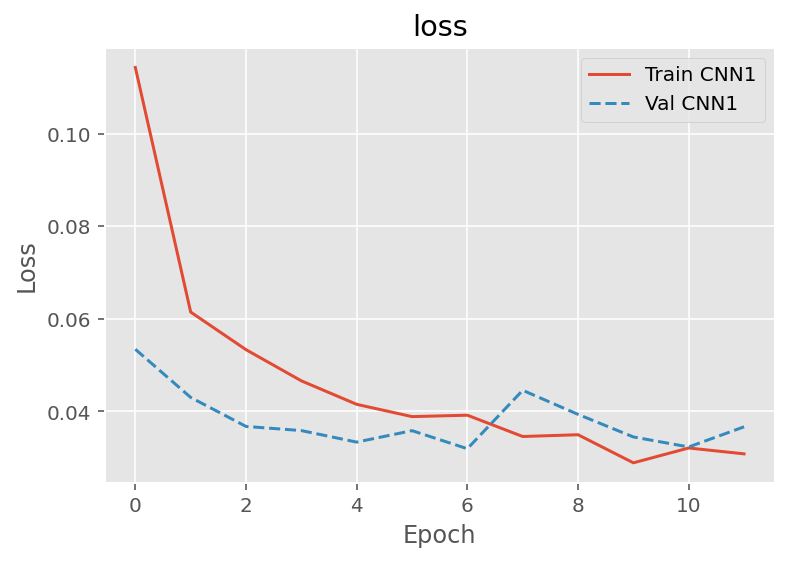

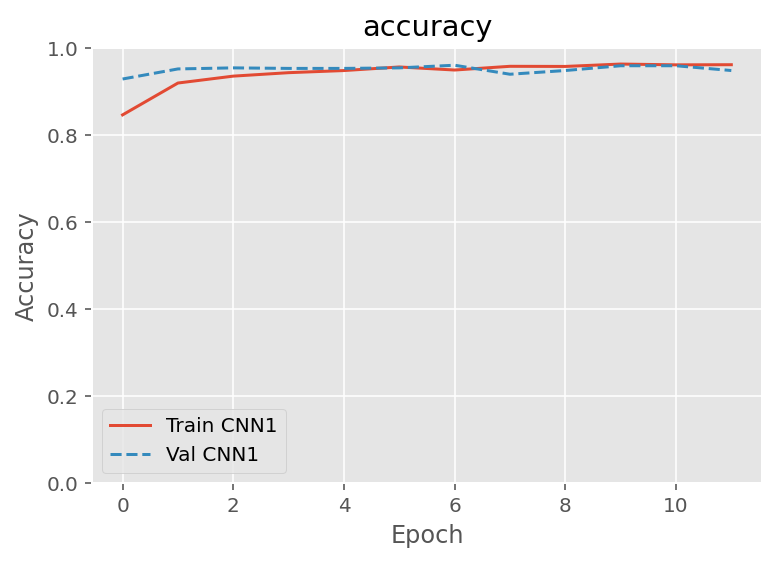

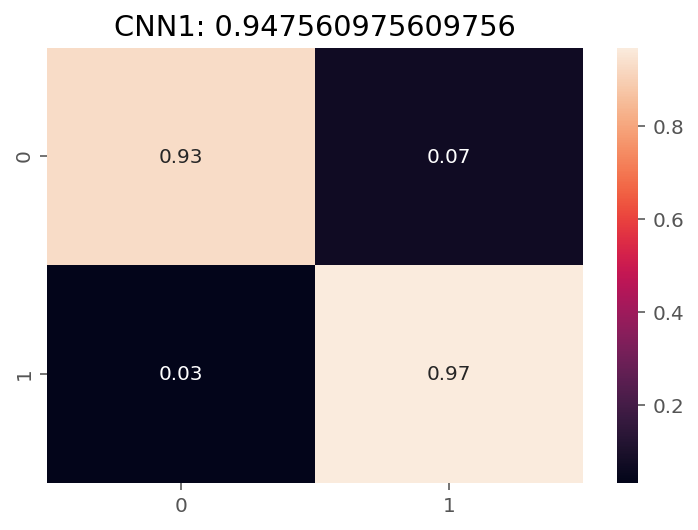

CPU times: user 1min 17s, sys: 2.11 s, total: 1min 19s
Wall time: 1min 6s


In [17]:
%%time
model1_eval = evaluate_model(model=cnn1,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'CNN1')
# model1_eval = evaluate_model(model=cnn1,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'CNN1',epochs=10)

Epoch 1/50
103/103 [==============================] - 5s 53ms/step - loss: 0.4124 - accuracy: 0.8336 - val_loss: 0.2508 - val_accuracy: 0.9159
Epoch 2/50
103/103 [==============================] - 5s 51ms/step - loss: 0.2578 - accuracy: 0.9023 - val_loss: 0.2377 - val_accuracy: 0.9012
Epoch 3/50
103/103 [==============================] - 5s 52ms/step - loss: 0.2217 - accuracy: 0.9154 - val_loss: 0.1861 - val_accuracy: 0.9341
Epoch 4/50
103/103 [==============================] - 5s 50ms/step - loss: 0.2160 - accuracy: 0.9124 - val_loss: 0.1679 - val_accuracy: 0.9427
Epoch 5/50
103/103 [==============================] - 5s 52ms/step - loss: 0.2002 - accuracy: 0.9234 - val_loss: 0.1610 - val_accuracy: 0.9451
Epoch 6/50
103/103 [==============================] - 5s 52ms/step - loss: 0.1952 - accuracy: 0.9237 - val_loss: 0.1682 - val_accuracy: 0.9317
Epoch 7/50
103/103 [==============================] - 5s 52ms/step - loss: 0.1865 - accuracy: 0.9310 - val_loss: 0.1620 - val_accuracy: 0.9378

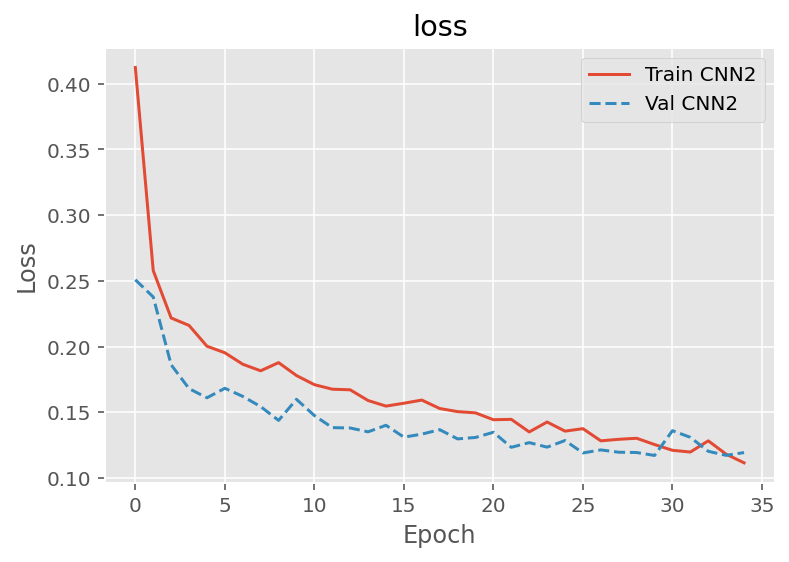

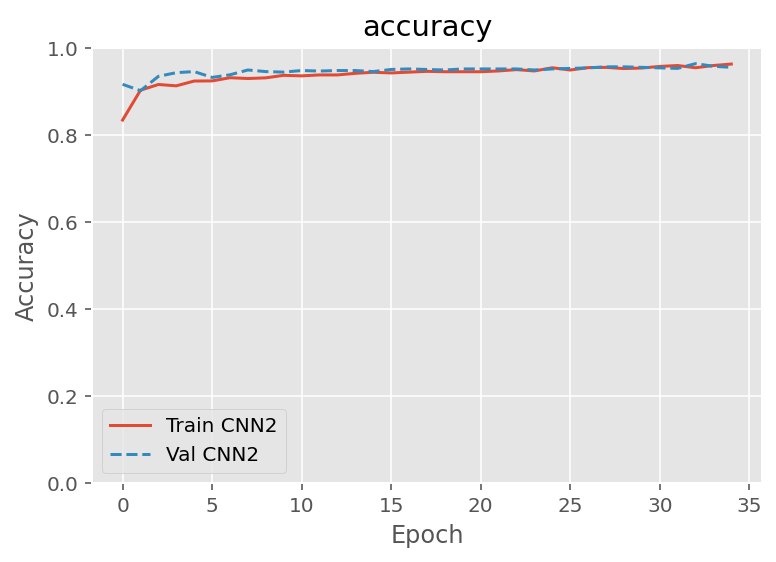

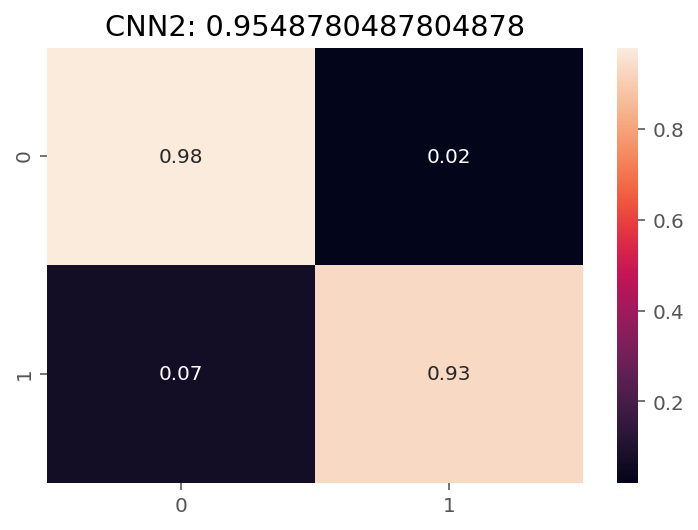

CPU times: user 3min 53s, sys: 3.28 s, total: 3min 57s
Wall time: 3min 11s


In [18]:
%%time
model2_eval = evaluate_model(model=cnn2,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'CNN2')
# model2_eval = evaluate_model(model=cnn2,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'CNN2',epochs=10)

### The CNN model 2 is better than CNN model 1 because not only higher accuracy but also higher AUROC.

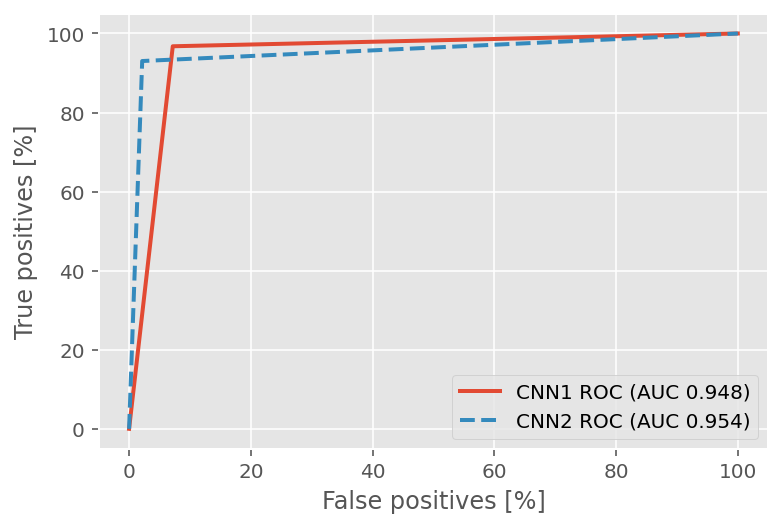

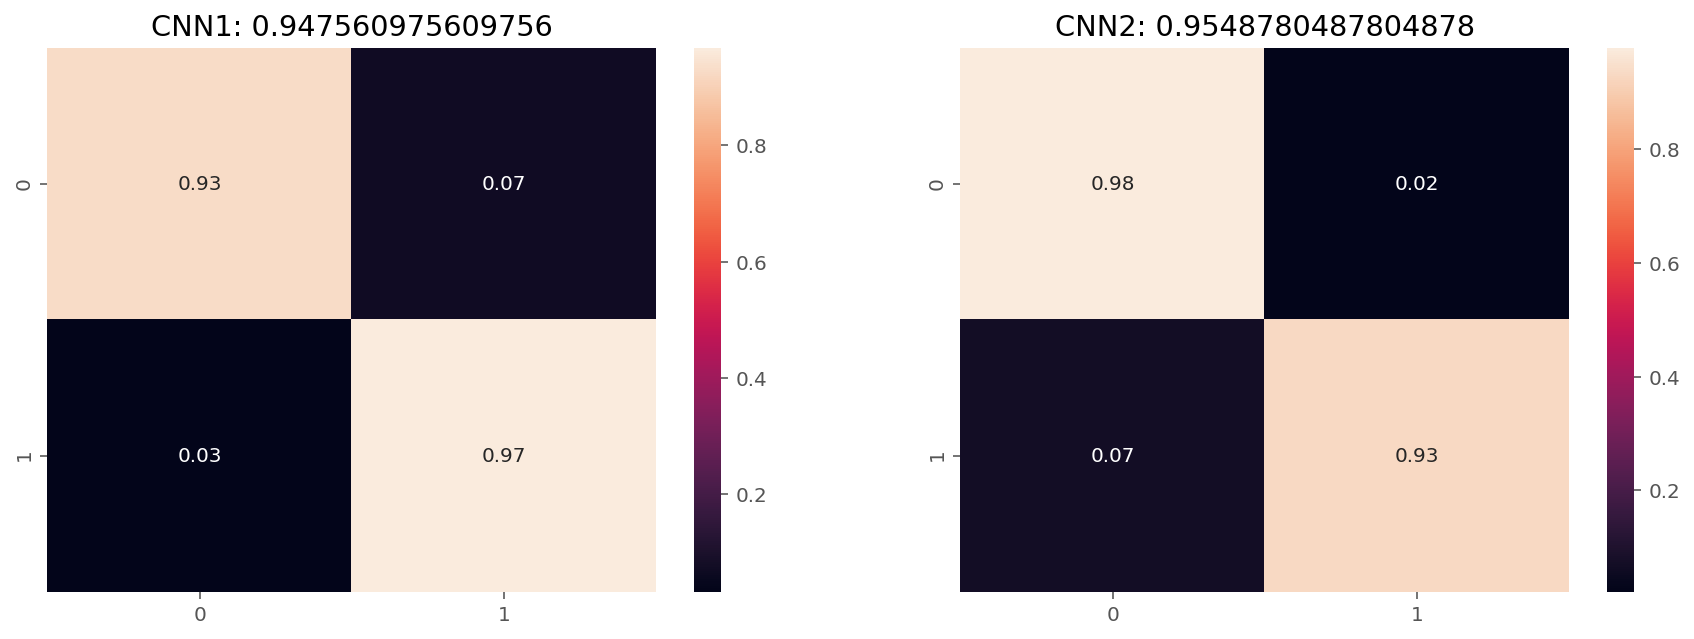

In [19]:
compare_model(model1_eval,model2_eval,'CNN1','CNN2')

### second CNN Model: The architecture is different from the one above. It has 4 convolution layers, 2 maxpooling, 3 perceptrons with dropout. I would call it CNN model 3.

In [20]:
cnn3 = Sequential() 
cnn3.add(
    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu',input_shape=(X_train.shape[1:]),data_format="channels_last")
)
cnn3.add(
    Conv2D(filters=64, kernel_size=3,strides=1, padding='same', activation='relu', data_format="channels_last")
)
cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last") 
)

cnn3.add(
    Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu',data_format="channels_last")
)
cnn3.add(
    Conv2D(filters=128, kernel_size=3,strides=1, padding='same', activation='relu', data_format="channels_last")
)
cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last") 
)

# add one layer on flattened output
cnn3.add( Flatten() )
cnn3.add(Dense(512,activation='relu'))
cnn3.add(Dropout(0.5))
cnn3.add(Dense(256,activation='relu'))
cnn3.add(Dropout(0.5))
cnn3.add(Dense(128,activation='relu'))
cnn3.add(Dropout(0.5))
cnn3.add( Dense(NUM_CLASSES,activation='sigmoid') )

cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)           

### The same architecture with the above one, but with variations altered. I change the Initializer for the kernel weights matrix and use l2 regulization, loss function and optimizer. I would call it CNN model 4. It might be my best model when I was designing.

In [21]:
l2_lambda = 0.0001
cnn4 = Sequential() 
cnn4.add(
    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda),input_shape=(X_train.shape[1:]),data_format="channels_last")
)
cnn4.add(
    Conv2D(filters=64, kernel_size=3,strides=1, padding='same', activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda),data_format="channels_last")
)
cnn4.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last") 
)

cnn4.add(
    Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda),data_format="channels_last")
)
cnn4.add(
    Conv2D(filters=128, kernel_size=3,strides=1, padding='same', activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda), data_format="channels_last")
)
cnn4.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last") 
)

# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add(Dense(512,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda)))
cnn4.add(Dropout(0.5))
cnn4.add(Dense(256,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda)))
cnn4.add(Dropout(0.5))
cnn4.add(Dense(128,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda)))
cnn4.add(Dropout(0.5))
cnn4.add( Dense(NUM_CLASSES,activation='sigmoid') )

cnn4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cnn4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)           

Epoch 1/50
103/103 [==============================] - 22s 213ms/step - loss: 0.4452 - accuracy: 0.5058 - val_loss: 0.1917 - val_accuracy: 0.8268
Epoch 2/50
103/103 [==============================] - 21s 202ms/step - loss: 0.1057 - accuracy: 0.8687 - val_loss: 0.0549 - val_accuracy: 0.9256
Epoch 3/50
103/103 [==============================] - 21s 202ms/step - loss: 0.0799 - accuracy: 0.9045 - val_loss: 0.0691 - val_accuracy: 0.9134
Epoch 4/50
103/103 [==============================] - 21s 202ms/step - loss: 0.0713 - accuracy: 0.9121 - val_loss: 0.0431 - val_accuracy: 0.9463
Epoch 5/50
103/103 [==============================] - 21s 202ms/step - loss: 0.0697 - accuracy: 0.9154 - val_loss: 0.0953 - val_accuracy: 0.8866
Epoch 6/50
103/103 [==============================] - 21s 202ms/step - loss: 0.0578 - accuracy: 0.9234 - val_loss: 0.0355 - val_accuracy: 0.9488
Epoch 7/50
103/103 [==============================] - 21s 202ms/step - loss: 0.0548 - accuracy: 0.9304 - val_loss: 0.0357 - val_ac

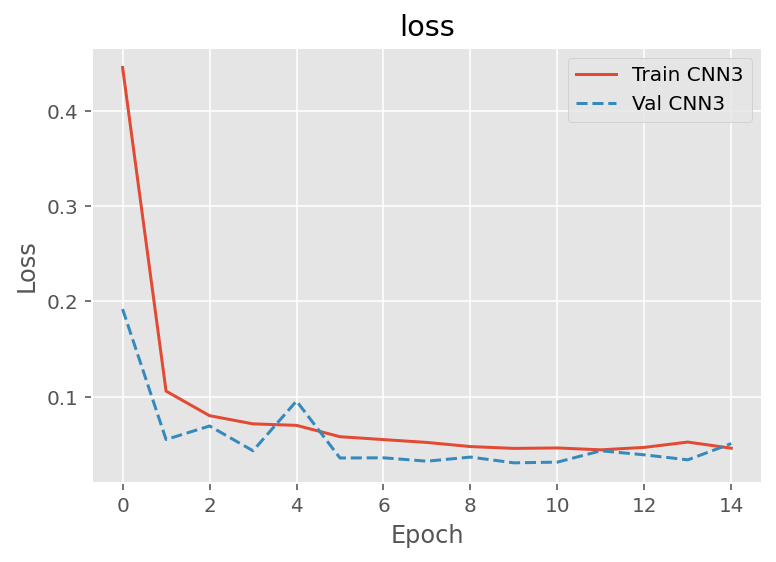

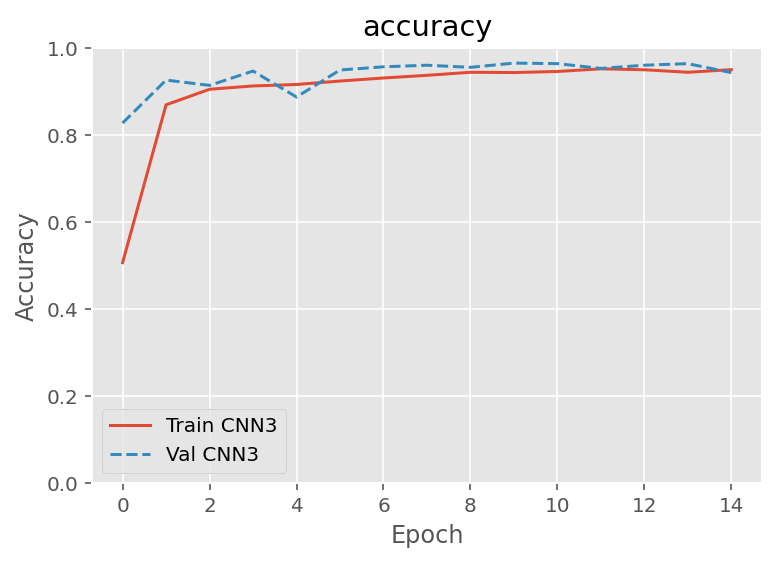

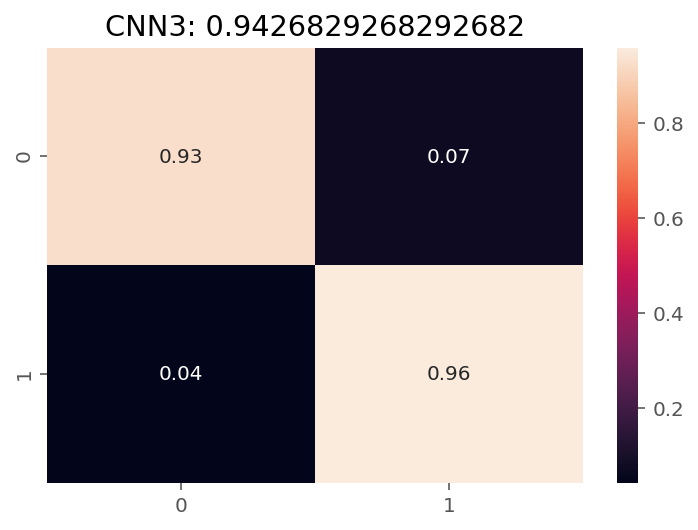

CPU times: user 5min 38s, sys: 1.92 s, total: 5min 40s
Wall time: 5min 19s


In [22]:
%%time
model3_eval = evaluate_model(model=cnn3,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'CNN3')

Epoch 1/50
103/103 [==============================] - 21s 202ms/step - loss: 1.1707 - accuracy: 0.7692 - val_loss: 0.6250 - val_accuracy: 0.8866
Epoch 2/50
103/103 [==============================] - 21s 201ms/step - loss: 0.6331 - accuracy: 0.8880 - val_loss: 0.5261 - val_accuracy: 0.9293
Epoch 3/50
103/103 [==============================] - 21s 201ms/step - loss: 0.5401 - accuracy: 0.9017 - val_loss: 0.4270 - val_accuracy: 0.9280
Epoch 4/50
103/103 [==============================] - 21s 201ms/step - loss: 0.4789 - accuracy: 0.9118 - val_loss: 0.4077 - val_accuracy: 0.9329
Epoch 5/50
103/103 [==============================] - 21s 201ms/step - loss: 0.4252 - accuracy: 0.9225 - val_loss: 0.3844 - val_accuracy: 0.9256
Epoch 6/50
103/103 [==============================] - 21s 201ms/step - loss: 0.4200 - accuracy: 0.9176 - val_loss: 0.4136 - val_accuracy: 0.9476
Epoch 7/50
103/103 [==============================] - 21s 201ms/step - loss: 0.3916 - accuracy: 0.9289 - val_loss: 0.3283 - val_ac

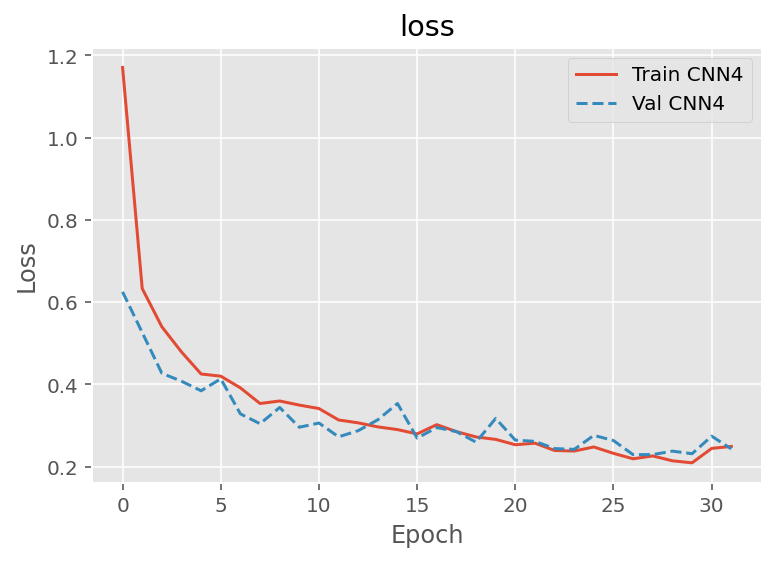

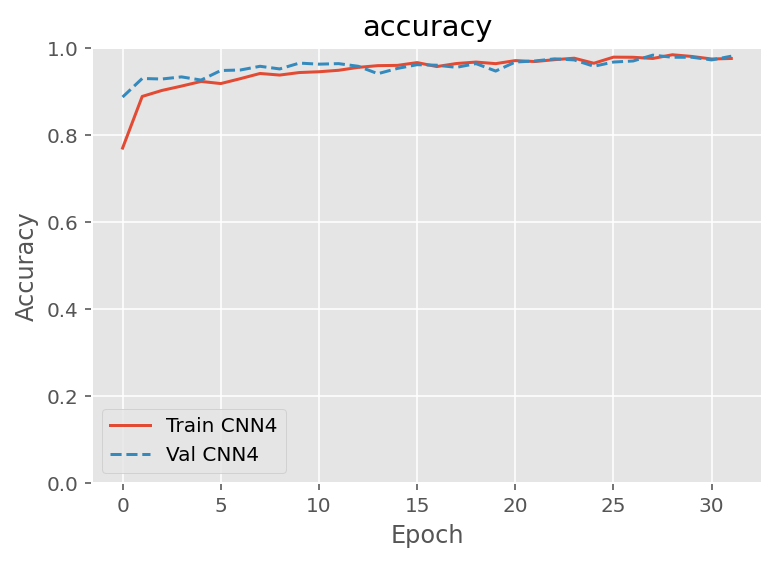

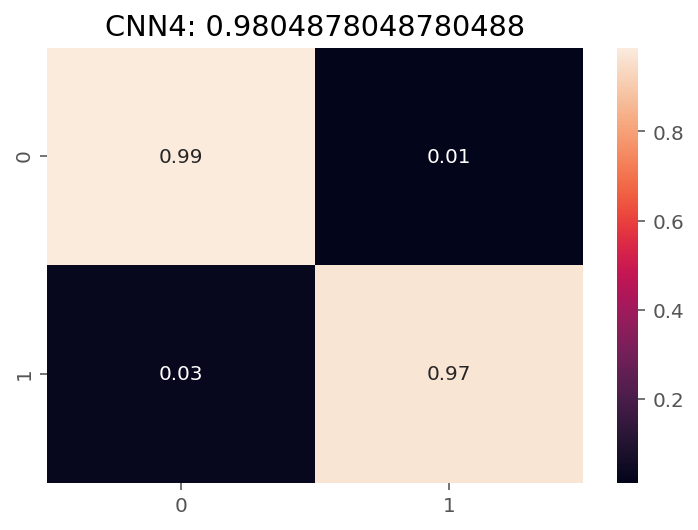

CPU times: user 10min 50s, sys: 5.12 s, total: 10min 55s
Wall time: 11min 11s


In [23]:
%%time
# model2_eval = evaluate_model(model=cnn2,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'cnn2',epochs=20,verbose=1)
model4_eval = evaluate_model(model=cnn4,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'CNN4')

### The CNN model 4 is better than CNN model 3. It is my best model.

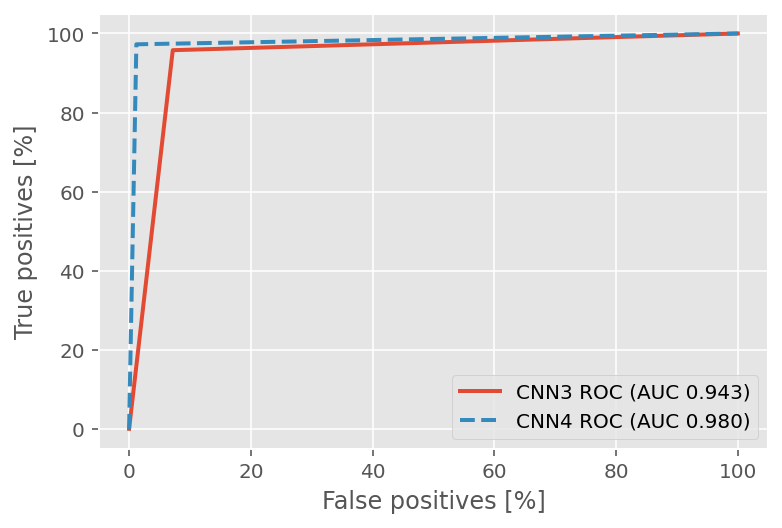

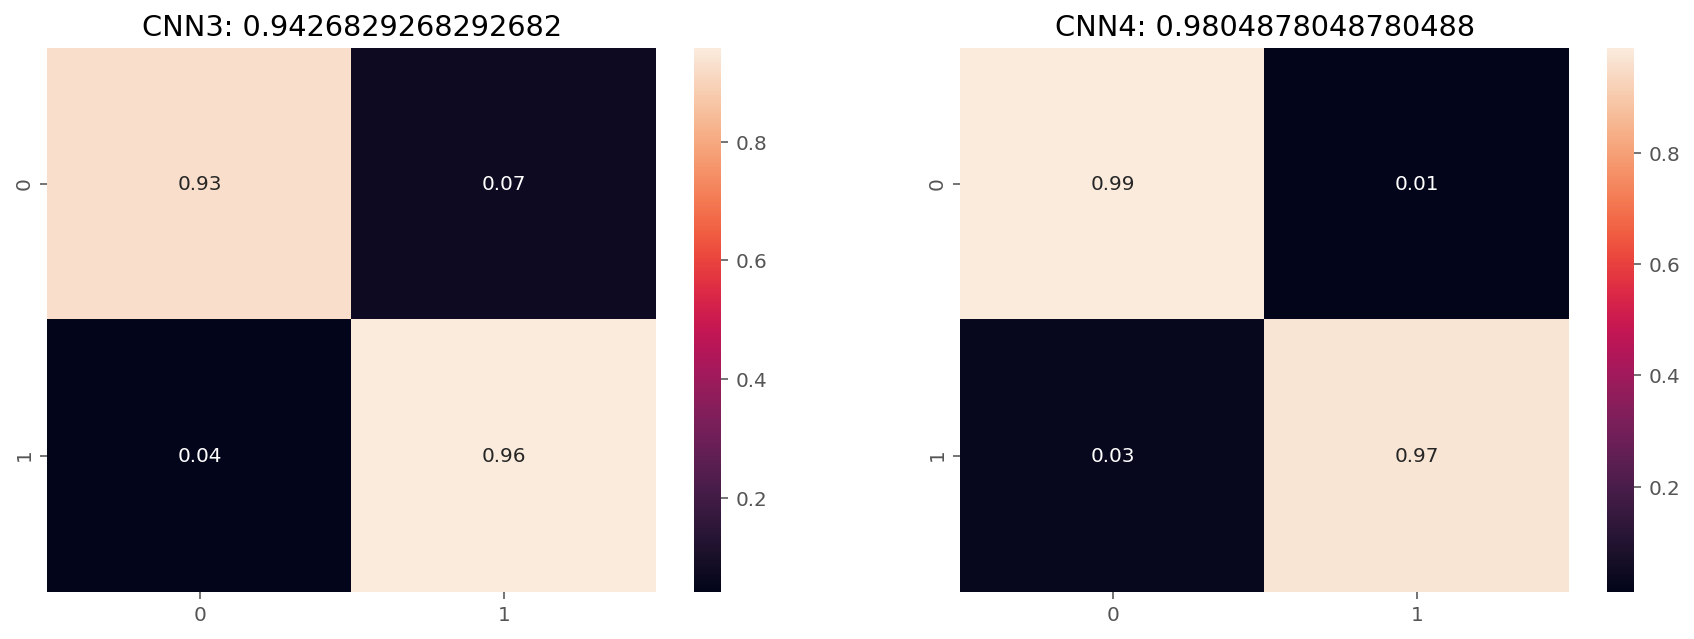

In [24]:
compare_model(model3_eval,model4_eval,'CNN3','CNN4')

### 2.4 Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.

### This is my MLP model.

In [25]:
%%time

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=X_train.shape[1], units=30, 
               activation='relu') )
mlp.add( Dense(units=1024, activation='relu'))
mlp.add(Dropout(0.5))
mlp.add( Dense(units=512, activation='relu') )
mlp.add(Dropout(0.5))
mlp.add( Dense(NUM_CLASSES,activation='sigmoid') )

mlp.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


CPU times: user 12 ms, sys: 42 µs, total: 12.1 ms
Wall time: 11.1 ms


Epoch 1/50
103/103 [==============================] - 5s 53ms/step - loss: 0.4884 - accuracy: 0.8071 - val_loss: 0.2820 - val_accuracy: 0.9061
Epoch 2/50
103/103 [==============================] - 5s 51ms/step - loss: 0.3091 - accuracy: 0.8837 - val_loss: 0.1958 - val_accuracy: 0.9207
Epoch 3/50
103/103 [==============================] - 5s 51ms/step - loss: 0.2542 - accuracy: 0.9069 - val_loss: 0.1976 - val_accuracy: 0.9232
Epoch 4/50
103/103 [==============================] - 5s 52ms/step - loss: 0.2189 - accuracy: 0.9182 - val_loss: 0.1966 - val_accuracy: 0.9159
Epoch 5/50
103/103 [==============================] - 5s 52ms/step - loss: 0.2234 - accuracy: 0.9154 - val_loss: 0.1722 - val_accuracy: 0.9244
Epoch 6/50
103/103 [==============================] - 5s 51ms/step - loss: 0.2179 - accuracy: 0.9249 - val_loss: 0.1626 - val_accuracy: 0.9415
Epoch 7/50
103/103 [==============================] - 5s 52ms/step - loss: 0.1999 - accuracy: 0.9325 - val_loss: 0.1727 - val_accuracy: 0.9244

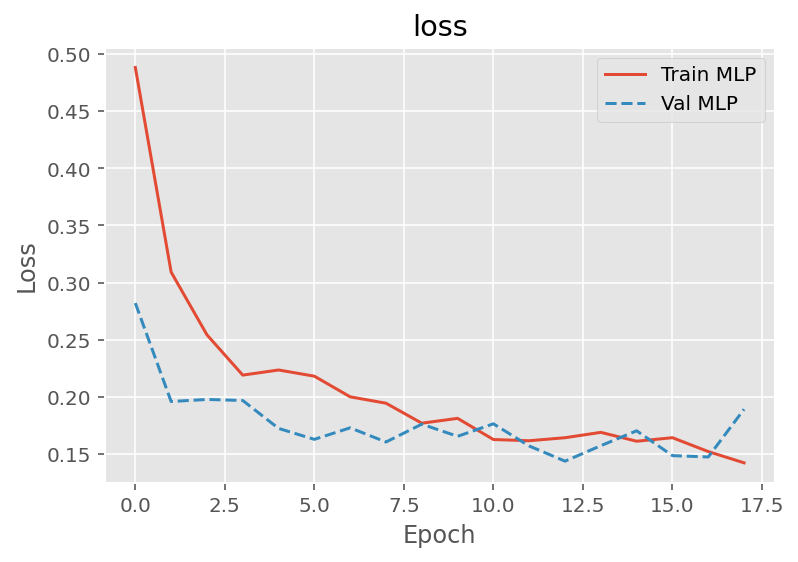

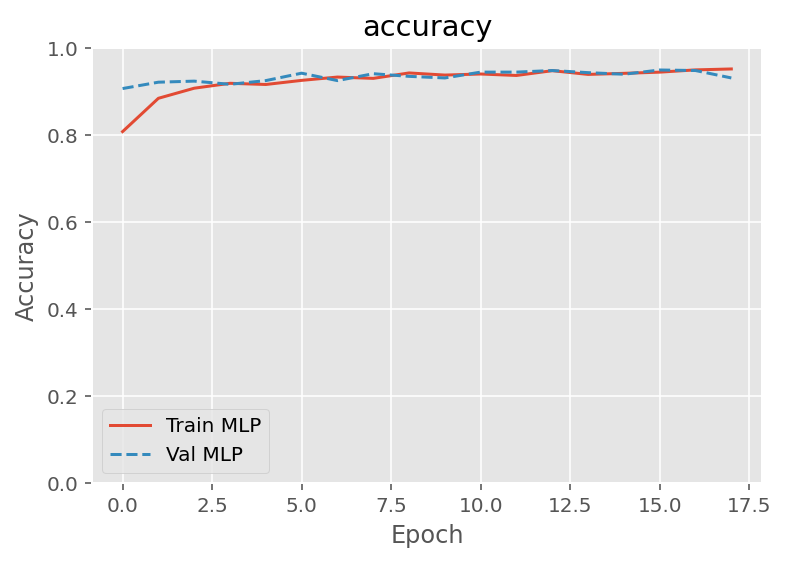

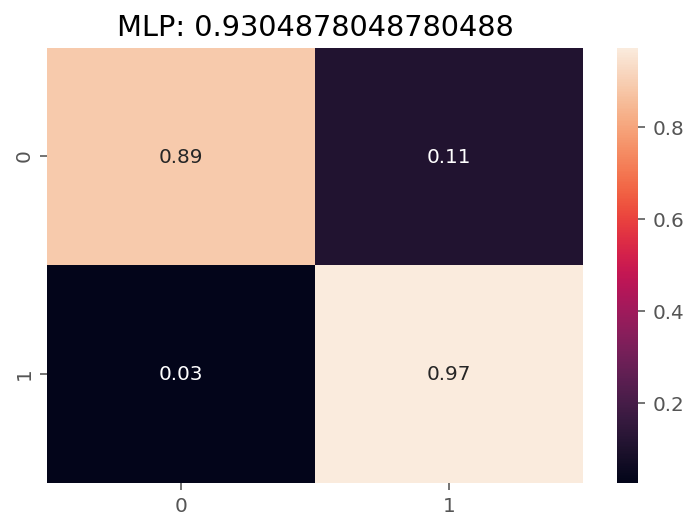

CPU times: user 1min 48s, sys: 2.04 s, total: 1min 50s
Wall time: 1min 37s


In [26]:
%%time
mlp_eval = evaluate_model(model=mlp,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'MLP',epochs=50,verbose=1)

### The CNN model 4 is better than my MLP due to both higher accuracy and AUROC.

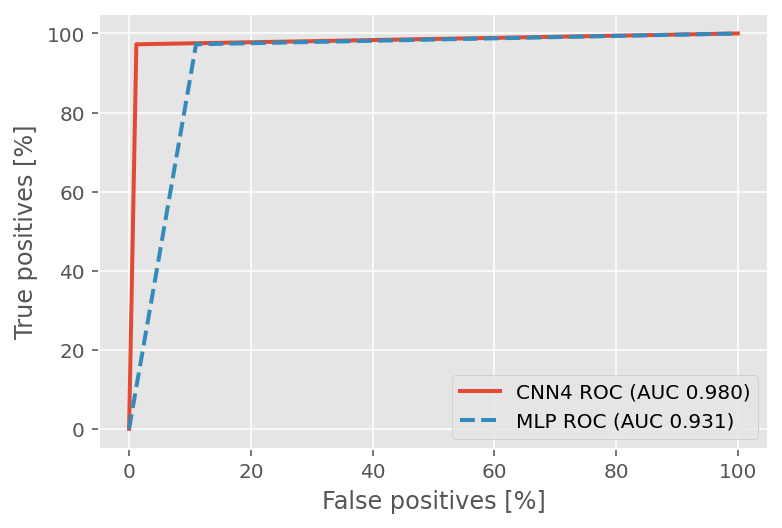

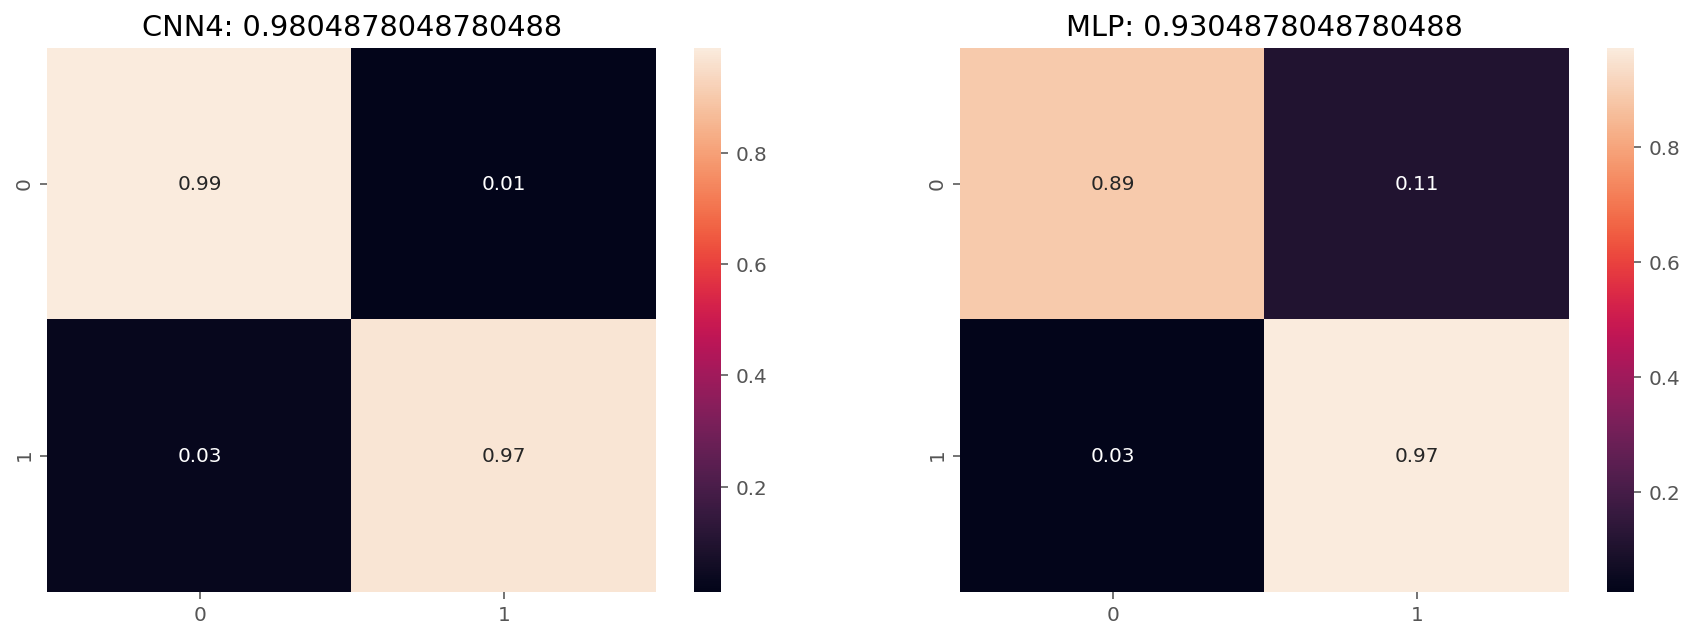

In [31]:
compare_model(model4_eval,mlp_eval,'CNN4','MLP')

## Exceptional Work (1 points total)
- You have free reign to provide additional analyses. 
- One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 

### I use resnet50 as my initial layer with already trained weights. I have tried VGG16, but it's result is not as good as the resnet50. I don't tried other keras' applications of more parameters because the video RAM of my graphic card don't allow me to do. 

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


cnn5 = Sequential()
cnn5.add(ResNet50(weights = 'imagenet',include_top=False ,pooling='avg'))
cnn5.add(Dense(1, activation = "sigmoid"))

cnn5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cnn5.get_layer('resnet50').trainable = False

cnn5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


### I have ever tried it's own preprocess_input function instead of mine, but the accuracy is around 50% and the loss can't be reduced after roughly 20 epochs. I'm confused, but I can't figure it out. If I just throw the raw image datas without any standardization or normalization into the preprocess_intput function, it would get at least 90% accuracy. Hence, I just leave it away.

In [28]:
# use the resnet's preprocess input
# data_gen = ImageDataGenerator(
#     preprocessing_function=preprocess_input
# )
# train_iter = data_gen.flow(X_train,y_train,batch_size=32)
# test_iter = (X_test,y_test)

Epoch 1/50
103/103 [==============================] - 29s 279ms/step - loss: 0.2023 - accuracy: 0.9344 - val_loss: 692.5703 - val_accuracy: 0.4902
Epoch 2/50
103/103 [==============================] - 27s 265ms/step - loss: 0.0894 - accuracy: 0.9670 - val_loss: 0.6923 - val_accuracy: 0.5220
Epoch 3/50
103/103 [==============================] - 27s 265ms/step - loss: 0.0593 - accuracy: 0.9811 - val_loss: 0.7033 - val_accuracy: 0.5098
Epoch 4/50
103/103 [==============================] - 27s 266ms/step - loss: 0.0485 - accuracy: 0.9850 - val_loss: 0.6895 - val_accuracy: 0.4939
Epoch 5/50
103/103 [==============================] - 27s 266ms/step - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.6945 - val_accuracy: 0.5098
Epoch 6/50
103/103 [==============================] - 27s 266ms/step - loss: 0.0585 - accuracy: 0.9808 - val_loss: 0.7086 - val_accuracy: 0.4939
Epoch 7/50
103/103 [==============================] - 27s 266ms/step - loss: 0.0405 - accuracy: 0.9875 - val_loss: 0.3688 - val_

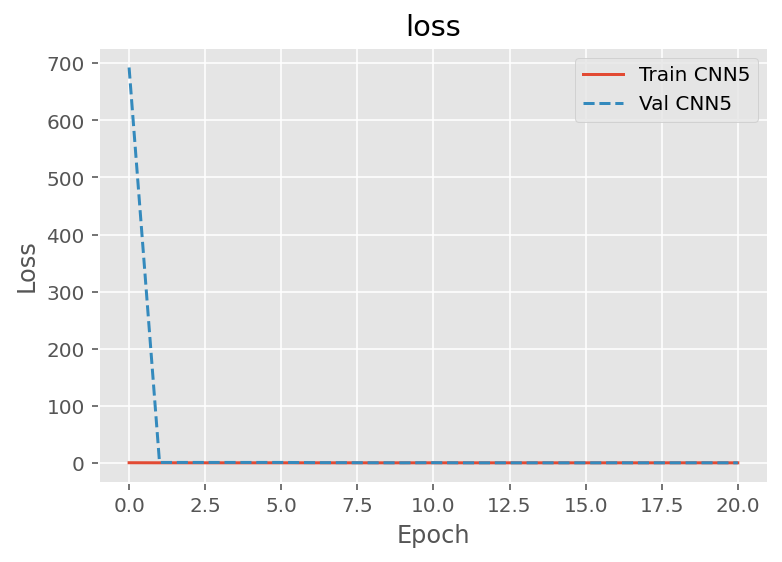

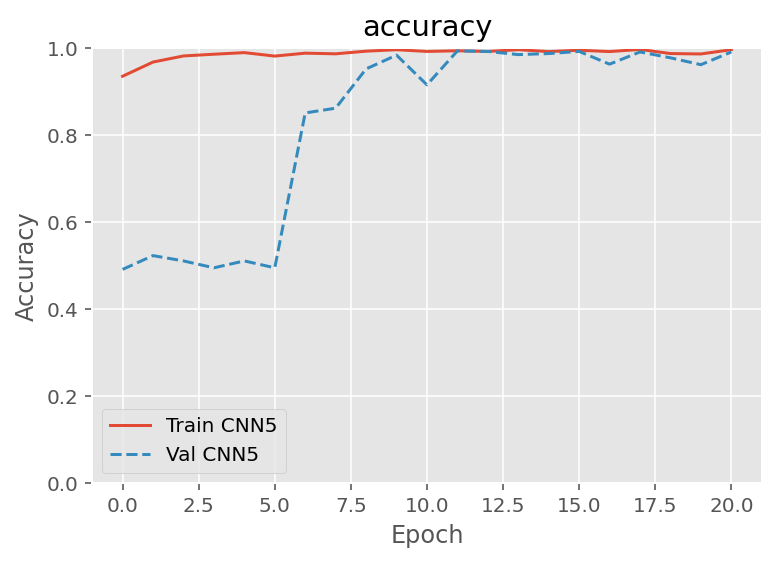

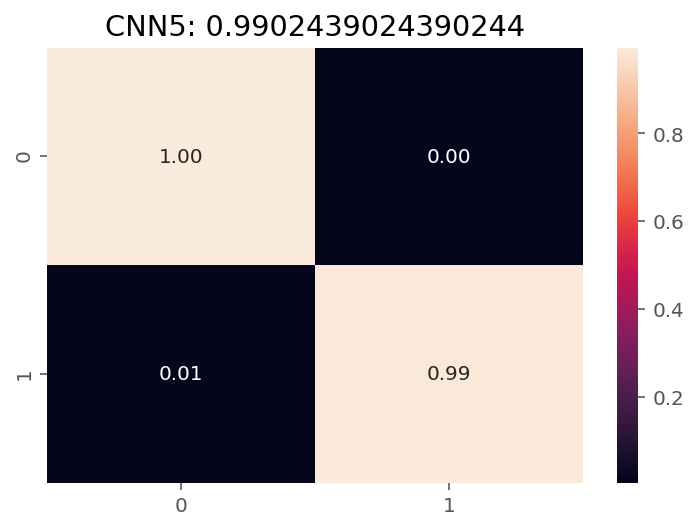

CPU times: user 8min 42s, sys: 3.3 s, total: 8min 46s
Wall time: 9min 49s


In [29]:
%%time
# model5_eval = evaluate_model(model=cnn4,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'cnn4',epochs=20,verbose=1)
model5_eval = evaluate_model(model=cnn5,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'CNN5')

### Obviously, it's better than my CNN4 model. 99% accuracy, so amazing number I have got! I have remembered in the lab2 the highest accuracy I got is 91% with daisy, which cost me 1.5 hours.

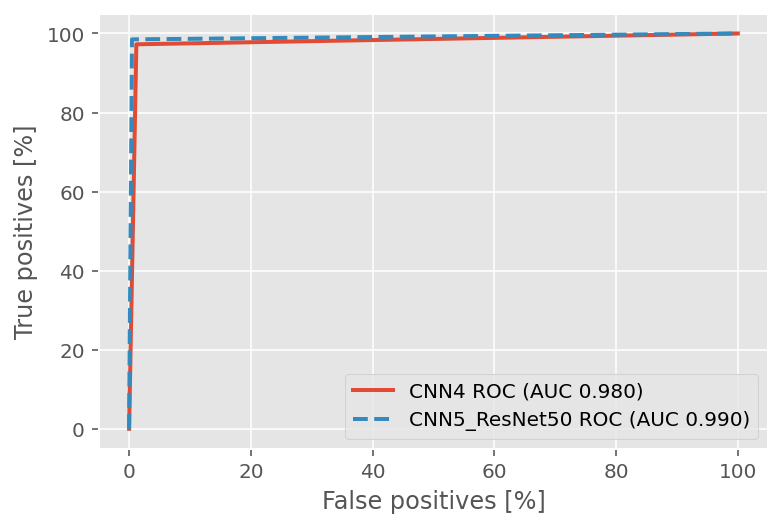

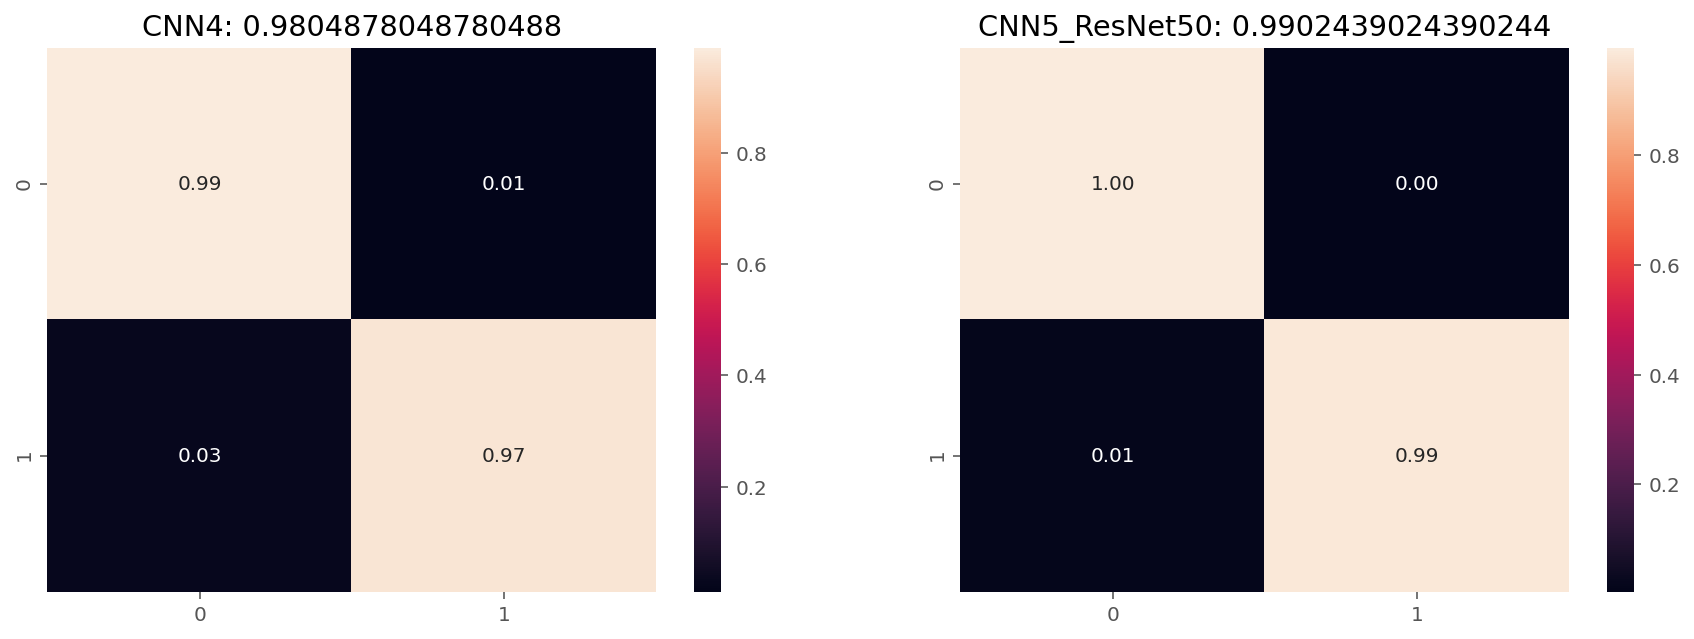

In [32]:
compare_model(model4_eval,model5_eval,'CNN4','CNN5_ResNet50')